In [1]:
# requires browser refresh after installation
!pip install ipympl -q


In [2]:
%matplotlib ipympl

In [3]:
import intake
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt

The spatial and temporal distribution of AR events as a function of AR scale category relies on vertically integrated vapor transport (IVT), which is calculated as 

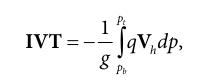

where 

- q is the specific humidity
- Vh is the horizontal wind vector
- g is the acceleration due to gravity
- pb is 1,000 hPa
- and pt is 200 hPa

The IVT is calculated using atmospheric data from the MERRA reanalysis at 0.5° × 0.625° horizontal resolution (Rienecker et al. 2011). Vertical levels used to calculate IVT are every 25 hPa from 1,000 to 700 hPa and every 50 hPa from 700 to 200 hPa.

In [4]:
# List the data available in the Intake Catalog
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)
catalog

,unique
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20
start_time,4


In [5]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/castronova/proxy/8787/status,
Dashboard: /user/castronova/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35221,Workers: 4
Dashboard: /user/castronova/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:43681,Total threads: 1
Dashboard: /user/castronova/proxy/33019/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:41877,


In [6]:
catalog_subset = catalog.search(variable='Q', frequency='daily')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,Q,specific humidity,atm,historical,cmip6,daily,32.0,global,kg/kg,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1,Q,specific humidity,atm,historical,smbb,daily,32.0,global,kg/kg,1850-01-01 12:00:00,2015-01-01 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2,Q,specific humidity,atm,ssp370,cmip6,daily,32.0,global,kg/kg,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...


In [7]:
catalog_subset = catalog.search(variable=['U', 'V'], frequency='daily')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,U,zonal wind,atm,historical,cmip6,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1,V,meridional wind,atm,historical,cmip6,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2,U,zonal wind,atm,historical,smbb,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
3,V,meridional wind,atm,historical,smbb,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
4,U,zonal wind,atm,ssp370,cmip6,daily,32.0,global,m/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...
5,V,meridional wind,atm,ssp370,cmip6,daily,32.0,global,m/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...


## Test Identifying 1980's AR Events

Load data from 1980 - 1989

In [8]:
ds = xr.open_dataset('b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

Select a single grid cell that covers Bodega Bay, CA (38.3332° N, 123.0481° W)

In [9]:
lat = 38.
lon = -123.125 + 360 
ds_ivt = ds.sel(lat=lat, lon=lon, method='nearest').IVT

Plot the IVT data for this cell 

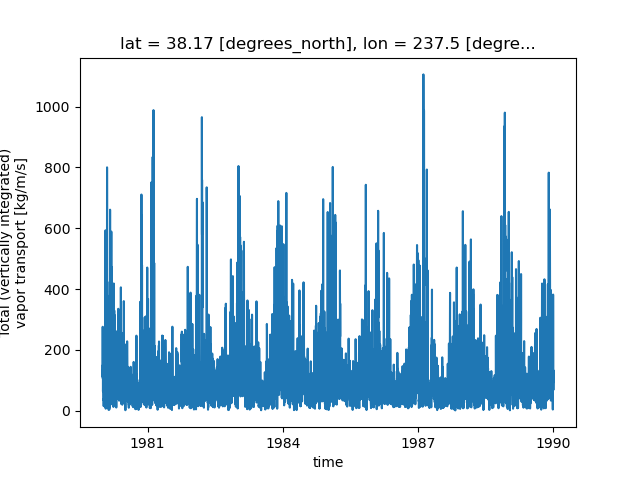

In [10]:
fig, ax = plt.subplots()
ds_ivt.plot();

Identify the 1986 AR event.

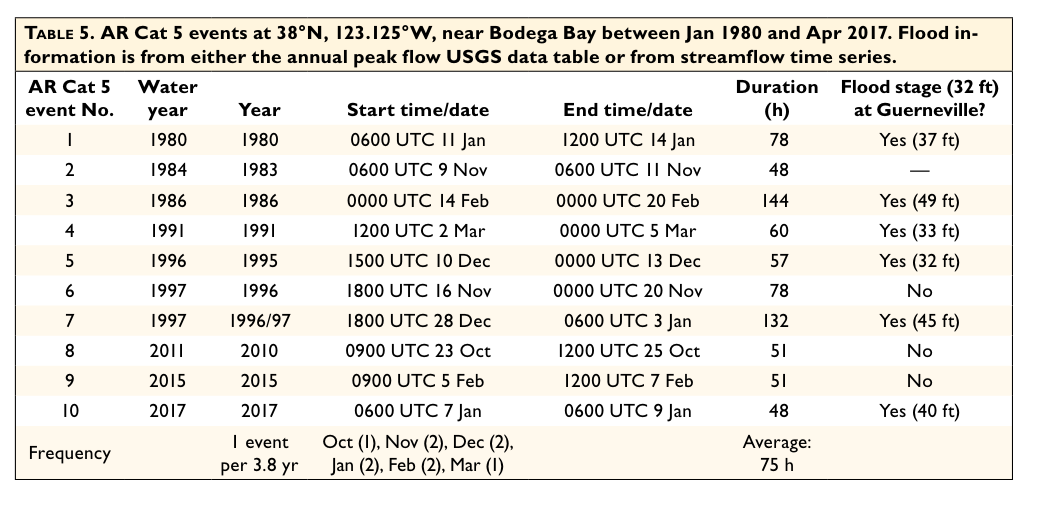


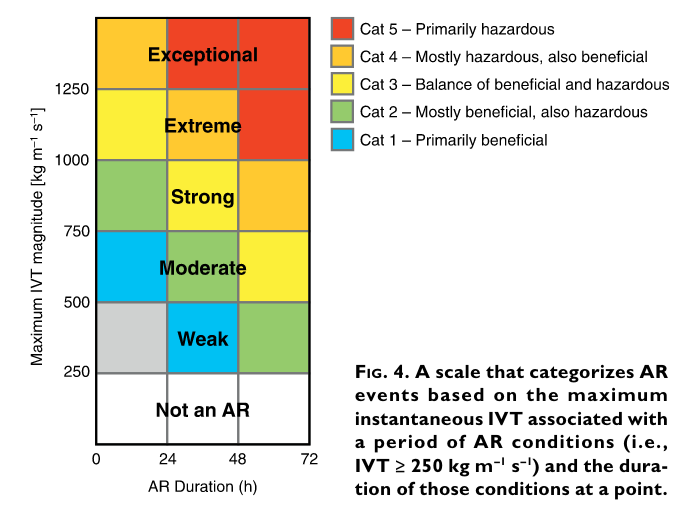

Subset the data temporally to capture a single event.

In [11]:
st = "1980-01-01"
et = "1989-12-31"
thr_low = 500
thr_high = 750
thr_ar_cond = 250 # threshold for AR events to be present

ds_subset = ds_ivt.sel(time=slice(st, et))

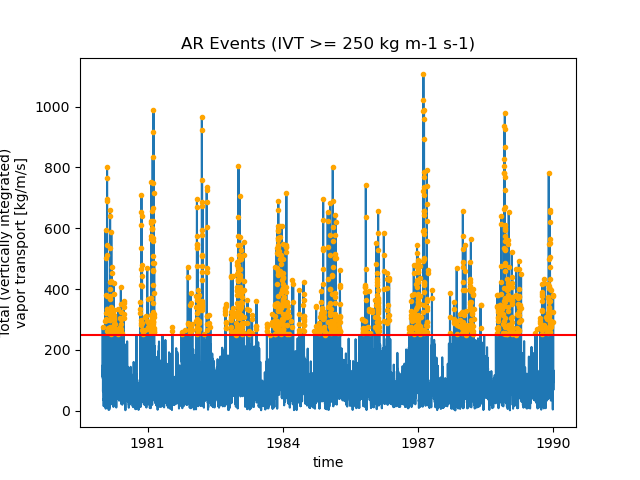

In [14]:
fig, ax = plt.subplots()
ds_subset.plot()
ds_subset.where((ds_subset >= thr_ar_cond)).plot(linestyle='', marker='.', color='orange')
ax.axhline(y=thr_ar_cond, color='red')
plt.title('AR Events (IVT >= 250 kg m-1 s-1)')
plt.show()

In [15]:
import xarray as xr
import numpy as np

def compute_ar_duration(xarray_array):
    # Flatten the array
    flattened = xarray_array.values
    flattened = np.insert(flattened, 0, 0, axis=0)
    flattened = np.append(flattened, 0)
    
    
    # Initialize variables
    count = 0
    current_sequence = 0
    idx_start = 0
    for idx in range(1, len(flattened)):

        # we hit a value of 1
        if flattened[idx] == 1:
            current_sequence += 1
            if flattened[idx - 1] == 0:
                # this is the first value in the set
                idx_start = idx
        
        # we hit a value of 0
        else:
            if current_sequence > 0:
                flattened[idx_start:idx] = current_sequence
            current_sequence = 0

    # return all but the first zero that we added
    return flattened[1:-1]

def create_ar_index(xarray_array):
    # Flatten the array
    flattened = xarray_array.values
    flattened = np.insert(flattened, 0, 0, axis=0)
    flattened = np.append(flattened, 0)
    
    
    # Initialize variables
    count = 0
    event = 0
    idx_start = 0
    for idx in range(1, len(flattened)):

        # we hit a value of 1
        if flattened[idx] == 1:
            
            if flattened[idx - 1] == 0:
                # this is the first value in the set
                idx_start = idx
                event += 1
        
        # we hit a value of 0
        else:
            flattened[idx_start:idx] = event

    # return all but the first zero that we added
    return flattened[1:-1]
        

Ideally we would have something that looks like this:


```
DataSet

time: [..., ..., ... ] 
IVT: [..., ..., ... ]
AR_ID: [0 0 1 1 1 1 1 1 0 2 2 2]
AR_DUR: [0 0 6 6 6 6 6 6 0 3 3 3]
AR_CAT: [..., ..., ... ]
```

```
cat = f(AR_DUR, IVT)
```


In [16]:
# isolate the days in which the minimum AR conditions are met.
ds_thr = xr.where((ds_subset >= thr_ar_cond), 1, 0)

# compute indices for each AR event
ar_index = create_ar_index(ds_thr)

# compute AR duration for each event
ar_duration = compute_ar_duration(ds_thr)

Add these computed values back to the dataset

In [17]:
dat = ds_subset.to_dataset()
dat['AR_ID'] = (['time'], ar_index)
dat['AR_DUR'] = (['time'], ar_duration)
dat['AR_CAT'] = (['time'], np.zeros(len(ar_index))) # create an empty array to store AR Category that will be computed later.
dat

<xarray.Dataset> Size: 526kB
Dimensions:  (time: 14600)
Coordinates:
    lat      float64 8B 38.17
    lon      float64 8B 237.5
  * time     (time) object 117kB 1980-01-01 00:00:00 ... 1989-12-31 18:00:00
Data variables:
    IVT      (time) float32 58kB 130.7 133.5 154.3 112.0 ... 67.99 84.58 108.8
    AR_ID    (time) int64 117kB 0 0 0 0 0 1 1 1 ... 327 327 327 327 327 327 327
    AR_DUR   (time) int64 117kB 0 0 0 0 0 1 0 0 0 0 0 ... 4 4 0 0 0 0 0 0 0 0 0
    AR_CAT   (time) float64 117kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Compute AR Category for each AR event.

In [18]:
grouped = dat[['IVT', 'AR_DUR']].groupby(dat['AR_ID']).max()

# compute AR Category by combining max_ivt and AR duration.
for ar_id, d in dat.groupby(dat['AR_ID']):
    
    max_ivt = d.IVT.max()
    duration = d.AR_DUR.max() # don't need max here, but we do need a single value so this works for now.

    # one day
    cat = 0
    if (duration > 0) & (duration <= 4):
        if (max_ivt >= 0) & (max_ivt < 250):
            cat = 0
        elif (max_ivt >= 250) & (max_ivt < 500):
            cat = 0
        elif (max_ivt >= 500) & (max_ivt < 750):
            cat = 1
        elif (max_ivt >= 750) & (max_ivt < 1000):
            cat = 2
        elif (max_ivt >= 1000) & (max_ivt < 1250):
            cat = 3
        elif (max_ivt >= 1250):
            cat = 4
    # 2 days
    if (duration > 4) & (duration <= 8):
        if (max_ivt >= 0) & (max_ivt < 250):
            cat = 0
        elif (max_ivt >= 250) & (max_ivt < 500):
            cat = 1
        elif (max_ivt >= 500) & (max_ivt < 750):
            cat = 2
        elif (max_ivt >= 750) & (max_ivt < 1000):
            cat = 3
        elif (max_ivt >= 1000) & (max_ivt < 1250):
            cat = 4
        elif (max_ivt >= 1250):
            cat = 5
    # 3 days or more
    if (duration > 8):
        if (max_ivt >= 0) & (max_ivt < 250):
            cat = 0
        elif (max_ivt >= 250) & (max_ivt < 500):
            cat = 2
        elif (max_ivt >= 500) & (max_ivt < 750):
            cat = 3
        elif (max_ivt >= 750) & (max_ivt < 1000):
            cat = 4
        elif (max_ivt >= 1000) & (max_ivt < 1250):
            cat = 5
        elif (max_ivt >= 1250):
            cat = 5

    dat['AR_CAT'] = dat['AR_CAT'].where(dat['AR_ID'] != ar_id, other = cat)

Text(0.5, 1.0, 'AR Categories')

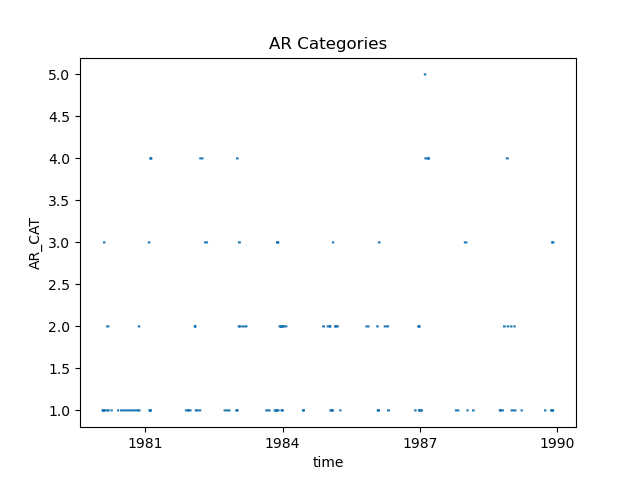

In [19]:
# plot AR Categories
fig, ax = plt.subplots()
dat.where(dat.AR_CAT > 0).AR_CAT.plot()
plt.title('AR Categories');

Filter where IVT is greater than 750 and less than 1000 because we only want significant events.

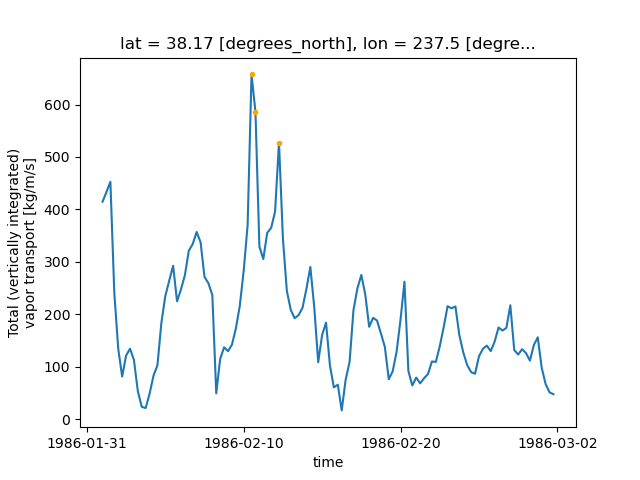

In [22]:
fig, ax = plt.subplots()
ds_subset.plot()
ds_subset.where((ds_subset >= thr_low) & (ds_subset < thr_high)).plot(linestyle='', marker='.', color='orange')
plt.show()

Set values where our criteria are met to 1.0 and all other locations to np.nan.

In [23]:
ds_thr = xr.where((ds_subset >= thr_low) & (ds_subset < thr_high), 1, np.nan)

Compute a rolling sum to calculate the number of consecutive days in which the criteria has been met.

In [35]:
ds_rolling = ds_thr.fillna(0).rolling(time=4, center=True).max()



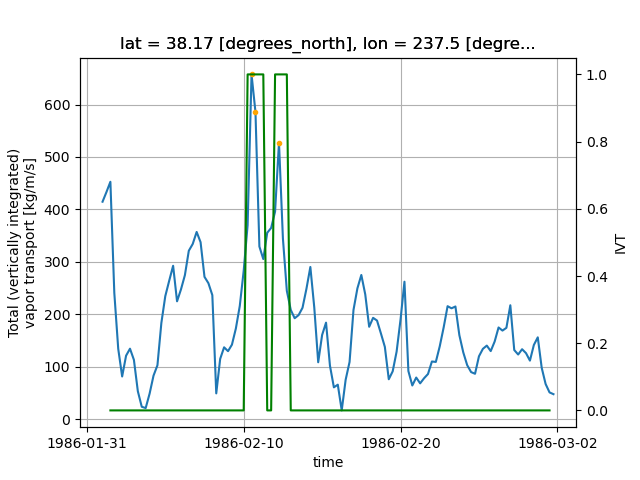

In [36]:
fig, ax = plt.subplots()


ds_subset.plot()
ds_subset.where((ds_subset >= thr_low) & (ds_subset < thr_high)).plot(linestyle='', marker='.', color='orange')

ax2 = ax.twinx()
ds_rolling.plot(color='green', ax=ax2)

ax.grid()

plt.show()

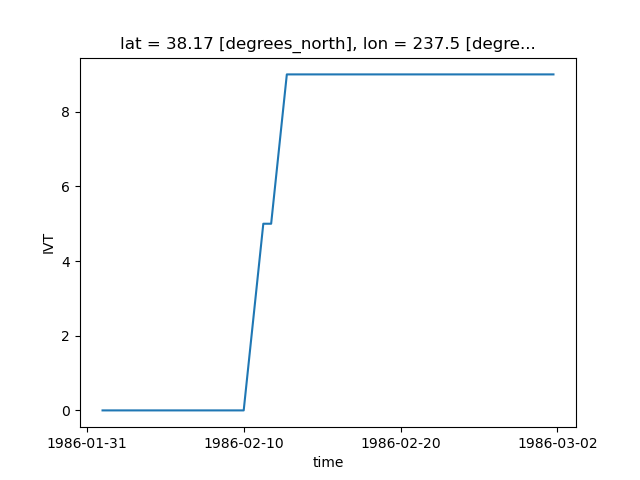

In [28]:
fig, ax = plt.subplots()
ds_rolling.cumsum().plot()
plt.show()

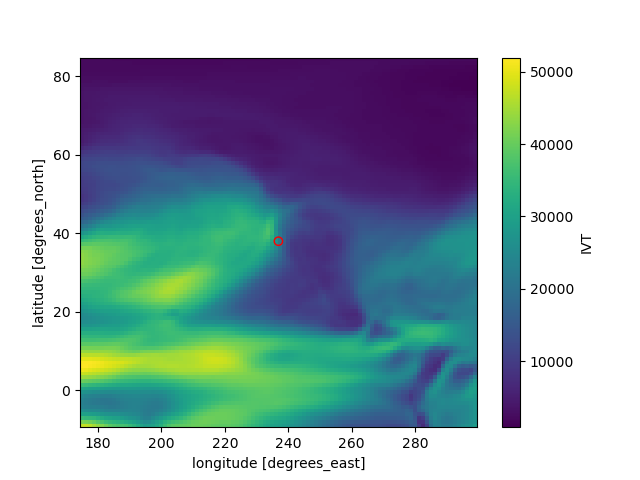

In [16]:
fig, ax = plt.subplots()

ilon = list(ds.lon.values).index(ds.sel(lon=lon, method='nearest').lon)
ilat = list(ds.lat.values).index(ds.sel(lat=lat, method='nearest').lat)

ds.sel(time=slice(st, et)).isel(lat=range(ilat-50, ilat+50), lon=range(ilon-50, ilon+50)).IVT.sum(dim='time').plot();
ax.scatter([lon], [lat], color='red', facecolor='None');